# Assignment 2

1. [Load the MNIST dataset](#1.-Load-the-MNIST-dataset)  
	1-1. [Devide the dataset into 3 splits with the ratios of train:val:test=5:1:1](#1-1.-Devide-the-dataset-into-3-splits-with-the-ratios-of-train:val:test=5:1:1)  
2. [Train a simple 2-layer MLP on the MNIST dataset](#2.-Train-a-simple-2-layer-MLP-on-the-MNIST-dataset)  
	2-1. [Tune the hyperparameters using the validation split](#2-1.-Tune-the-hyperparameters-using-the-validation-split)  
	2-2. [Report test accuracy(%)](#2-2.-Report-test-accuracy(%))  
	2-3. [Plot the training curve](#2-3.-Plot-the-training-curve)  
	2-4. [Plot the validation curve](#2-4.-Plot-the-validation-curve)  
3. [Try to improve model](#3.-Improve-model)  
	3-1. [Add dropout](#3-1.-Add-dropout)  
	3-2. [Apply data augmentation (visualization)](#3-2.-Apply-data-augmentation-(visualization))  
	3-3. [Change the depth of the network](#3-3.-Change-the-depth-of-the-network)  
	3-4. [Change the optimizer or learning rate scheduler](#3-4.-Change-the-optimizer-or-learning-rate-scheduler)  
	3-5. [Add L2 regularization](#3-5.-Add-L2-regularization)

In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, ColorJitter, RandomAffine, RandomResizedCrop, RandomRotation
import matplotlib.pyplot as plt
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using {} device..".format(device))

if device == 'cuda':
    torch.cuda.manual_seed(1)
    torch.cuda.manual_seed_all(1)
    #torch.backends.cudnn.deterministic=True
else:
    torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

using cuda device..


## 1. Load the MNIST dataset

In MNIST Dataset, there are 70000 images.  

### 1-1. Devide the dataset into 3 splits with the ratios of train:val:test=5:1:1

60000 images for train, 10000 images for test.  
Randomly split train dataset with 5:1 ratio for train and validation.  

In [23]:
data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_data, val_data = random_split(data, [50000, 10000])

print("length of train data: ", len(train_data))
print("length of val data: ", len(val_data))
print("length of test data: ", len(test_data))

length of train data:  50000
length of val data:  10000
length of test data:  10000


In [24]:
batch_size = 512

In [5]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

# 2. Train a simple 2-layer MLP on the MNIST dataset

Define a class to define 2-layer MLP which takes hidden_dimension as a hyperparameter


## 2-1. Tune the hyperparameters using the validation split
- 2-1-1. [the size of the hidden layers](#2-1-1.the-size-of-the-hidden-layers)
- 2-1-2. [learning rate](#2-1-2.learning-rate)
- 2-2-3. [the number of epochs](#2-1-3.the-number-of-epochs)

In [6]:
class MLP1(nn.Module):
    def __init__(self, hidden_dim):
        super(MLP1, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits 

In [7]:
def train(dataloader, model, criterion, optimizer):
    train_loss = 0
    for idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate average train loss
        train_loss += loss.item()/len(dataloader)

        if idx % 30 == 0:
            print(f"{idx:>4}th batch loss: {loss.item():>7f} [{idx*batch_size:>5d}/{len(dataloader.dataset):>5d}]")
    return train_loss

In [8]:
def val(dataloader, model):
    model.eval()
    val_loss, n_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += criterion(pred, y).item()
            n_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= len(dataloader)
    n_correct /= len(dataloader.dataset)
    print(f"Validation Error: \n Accuracy: {(100*n_correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return n_correct, val_loss

In [9]:
criterion = nn.CrossEntropyLoss()

### 2-1-1.the size of the hidden layers

Let's find the best size of hidden dimension for 2-layer MLP  
We are going to test four sizes : 1024, 512, 256, 128
(For the convenience, set learning rate = 1e-3)

In [10]:
dims = [1024, 512, 256, 128]
learning_rate = 1e-3
epochs = 10

val_accuracy, val_loss = dict(), dict()
for d in dims:
    model = MLP1(d).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    accuracy, loss = list(), list()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        _= train(train_dataloader, model, criterion, optimizer) 
        temp1, temp2 = val(val_dataloader, model)
        accuracy.append(temp1)
        loss.append(temp2)
    
    val_accuracy[d] = accuracy
    val_loss[d] = loss

Epoch 1
-------------------------------
   0th batch loss: 2.301632 [    0/50000]
  50th batch loss: 2.292988 [25600/50000]
Validation Error: 
 Accuracy: 17.7%, Avg loss: 2.281899 

Epoch 2
-------------------------------
   0th batch loss: 2.284969 [    0/50000]
  50th batch loss: 2.271554 [25600/50000]
Validation Error: 
 Accuracy: 35.2%, Avg loss: 2.256856 

Epoch 3
-------------------------------
   0th batch loss: 2.258820 [    0/50000]
  50th batch loss: 2.247693 [25600/50000]
Validation Error: 
 Accuracy: 45.9%, Avg loss: 2.229995 

Epoch 4
-------------------------------
   0th batch loss: 2.236563 [    0/50000]
  50th batch loss: 2.221757 [25600/50000]
Validation Error: 
 Accuracy: 52.3%, Avg loss: 2.203209 

Epoch 5
-------------------------------
   0th batch loss: 2.218275 [    0/50000]
  50th batch loss: 2.185577 [25600/50000]
Validation Error: 
 Accuracy: 56.6%, Avg loss: 2.176256 

Epoch 6
-------------------------------
   0th batch loss: 2.175739 [    0/50000]
  50th b

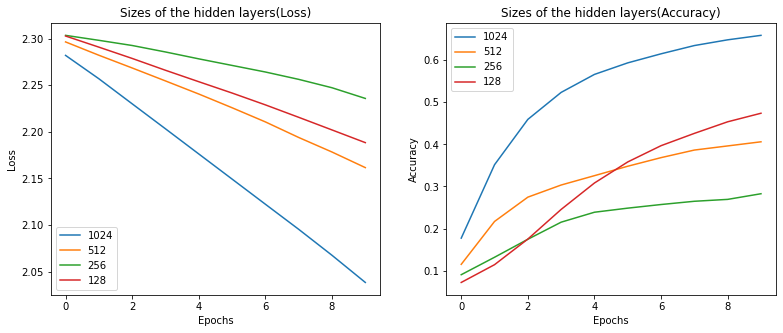

In [11]:
# Comparing between different sizes of the hidden layers
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Sizes of the hidden layers(Loss)')
for d in dims:
    ax1.plot(range(epochs), val_loss[d], label=d)
    ax1.legend(dims)

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Sizes of the hidden layers(Accuracy)')
for d in dims:
    ax2.plot(range(epochs), val_accuracy[d], label=d)
    ax2.legend(dims)
    
plt.show()

As the result, the best option for the hidden layers was 1024.  
Therefore, let's fix the size of the hidden layers to 1024

In [10]:
hidden_dim = 1024

### 2-1-2.learning-rate

From now on, let's find the most proper learning rate for our model.  
First, we will try 5 options(1e-1, 1e-2, 1e-3, 1e-4, 1e-5) with few epochs.  
And then, with more epochs, we will do finer search.

In [13]:
# Tune learning rates(try only few epochs)
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
epochs = 5

val_accuracy, val_loss = dict(), dict()

for learning_rate in learning_rates:
    #initialize shallow network with uniform weight initializer
    model = MLP1(hidden_dim).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    accuracy, loss = list(), list()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        _= train(train_dataloader, model, criterion, optimizer) 
        temp1, temp2 = val(val_dataloader, model)
        accuracy.append(temp1)
        loss.append(temp2)
    
    val_accuracy[learning_rate] = accuracy
    val_loss[learning_rate] = loss

Epoch 1
-------------------------------
   0th batch loss: 2.306780 [    0/50000]
  50th batch loss: 1.232135 [25600/50000]
Validation Error: 
 Accuracy: 74.6%, Avg loss: 0.849580 

Epoch 2
-------------------------------
   0th batch loss: 0.860616 [    0/50000]
  50th batch loss: 0.723723 [25600/50000]
Validation Error: 
 Accuracy: 80.7%, Avg loss: 0.652854 

Epoch 3
-------------------------------
   0th batch loss: 0.667621 [    0/50000]
  50th batch loss: 0.579665 [25600/50000]
Validation Error: 
 Accuracy: 83.6%, Avg loss: 0.589407 

Epoch 4
-------------------------------
   0th batch loss: 0.567738 [    0/50000]
  50th batch loss: 0.553867 [25600/50000]
Validation Error: 
 Accuracy: 85.0%, Avg loss: 0.553085 

Epoch 5
-------------------------------
   0th batch loss: 0.551091 [    0/50000]
  50th batch loss: 0.554495 [25600/50000]
Validation Error: 
 Accuracy: 86.0%, Avg loss: 0.532225 

Epoch 1
-------------------------------
   0th batch loss: 2.307896 [    0/50000]
  50th b

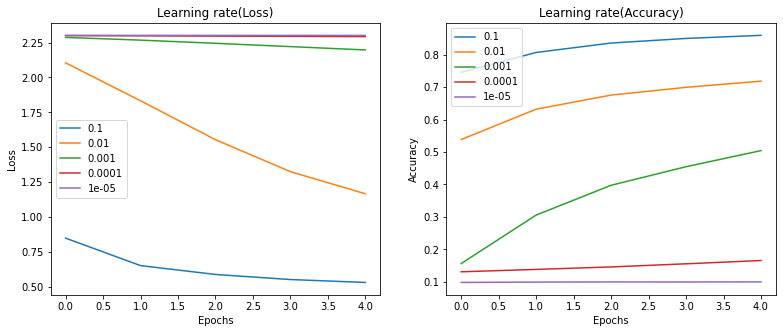

In [14]:
# Comparing between learning rates
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Learning rate(Loss)')
for lr in learning_rates:
    ax1.plot(range(epochs), val_loss[lr], label=lr)
    ax1.legend(learning_rates)

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Learning rate(Accuracy)')
for lr in learning_rates:
    ax2.plot(range(epochs), val_accuracy[lr], label=lr)
    ax2.legend(learning_rates)
    
plt.show()

Do finer search between 5e-2 ~ 1e-3 to find the most proper learning rate for our model.

In [22]:
# Tune learning rates(finer search)
learning_rates = [5e-2, 1e-2, 5e-3, 1e-3]
epochs = 10

val_accuracy, val_loss = dict(), dict()

for learning_rate in learning_rates:
    model = MLP1(hidden_dim).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    accuracy, loss = list(), list()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        _= train(train_dataloader, model, criterion, optimizer) 
        temp1, temp2 = val(val_dataloader, model)
        accuracy.append(temp1)
        loss.append(temp2)
    
    val_accuracy[learning_rate] = accuracy
    val_loss[learning_rate] = loss

Epoch 1
-------------------------------
   0th batch loss: 2.308672 [    0/50000]
  50th batch loss: 1.784033 [25600/50000]
Validation Error: 
 Accuracy: 58.4%, Avg loss: 1.510745 

Epoch 2
-------------------------------
   0th batch loss: 1.470161 [    0/50000]
  50th batch loss: 1.305932 [25600/50000]
Validation Error: 
 Accuracy: 60.8%, Avg loss: 1.255041 

Epoch 3
-------------------------------
   0th batch loss: 1.201398 [    0/50000]
  50th batch loss: 1.185862 [25600/50000]
Validation Error: 
 Accuracy: 61.1%, Avg loss: 1.163923 

Epoch 4
-------------------------------
   0th batch loss: 1.102269 [    0/50000]
  50th batch loss: 1.141715 [25600/50000]
Validation Error: 
 Accuracy: 61.6%, Avg loss: 1.107999 

Epoch 5
-------------------------------
   0th batch loss: 1.109154 [    0/50000]
  50th batch loss: 1.019777 [25600/50000]
Validation Error: 
 Accuracy: 62.1%, Avg loss: 1.072832 

Epoch 6
-------------------------------
   0th batch loss: 1.034487 [    0/50000]
  50th b

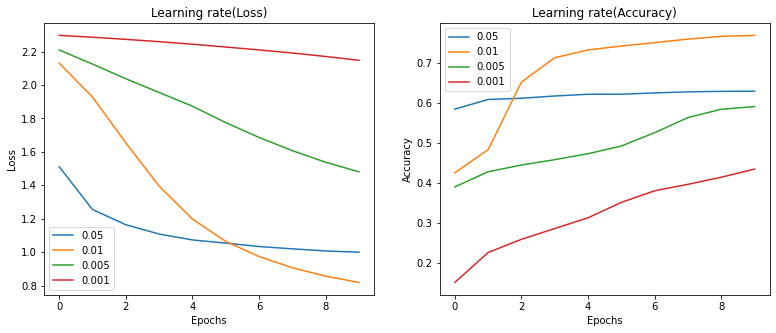

In [23]:
# Comparing between learning rates
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Learning rate(Loss)')
for lr in learning_rates:
    ax1.plot(range(epochs), val_loss[lr], label=lr)
    ax1.legend(learning_rates)

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Learning rate(Accuracy)')
for lr in learning_rates:
    ax2.plot(range(epochs), val_accuracy[lr], label=lr)
    ax2.legend(learning_rates)
    
plt.show()

As you can see, the loss smoothly and efficiently decreases with 0.01 learning rate.  
Therefore, the best learning rate is 0.01

In [11]:
learning_rate=1e-2

### 2-1-3.the-number-of-epochs

From now on, let's decide the number of epochs with the hyperparameters.  
(the size of the hidden layers = 1024, learning rate=0.01)  
We are going to train the model with a huge number of epochs and then check the traing and validation loss curve.

In [25]:
epochs = 400

model = MLP1(hidden_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
train_loss, val_loss = list(), list()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    _, loss = val(val_dataloader, model)
    val_loss.append(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.311326 [    0/50000]
  50th batch loss: 2.220334 [25600/50000]
Validation Error: 
 Accuracy: 50.4%, Avg loss: 2.123974 

Epoch 2
-------------------------------
   0th batch loss: 2.130002 [    0/50000]
  50th batch loss: 1.994576 [25600/50000]
Validation Error: 
 Accuracy: 62.1%, Avg loss: 1.876327 

Epoch 3
-------------------------------
   0th batch loss: 1.884794 [    0/50000]
  50th batch loss: 1.719763 [25600/50000]
Validation Error: 
 Accuracy: 66.5%, Avg loss: 1.608915 

Epoch 4
-------------------------------
   0th batch loss: 1.627308 [    0/50000]
  50th batch loss: 1.478523 [25600/50000]
Validation Error: 
 Accuracy: 68.5%, Avg loss: 1.381418 

Epoch 5
-------------------------------
   0th batch loss: 1.403992 [    0/50000]
  50th batch loss: 1.300360 [25600/50000]
Validation Error: 
 Accuracy: 70.6%, Avg loss: 1.210356 

Epoch 6
-------------------------------
   0th batch loss: 1.208875 [    0/50000]
  50th b

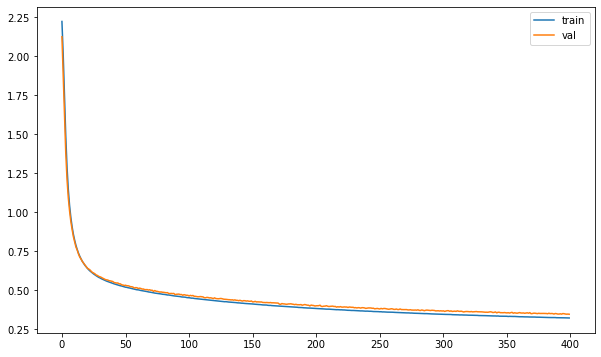

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='val')
plt.legend(['train', 'val'])

As the graph shows, training loss and validation loss decrease continuously.  
However, after 250 epochs, validation loss dose not decrease as much as train loss.  
Therefore, the best choice for the epoch is 250.

Now, let's train our model with the hyperparameters we found.  
- the size of the hidden layers = 1024
- learning rate = 1e-2
- the number of the epochs = 250

In [12]:
epoch = 250

In [29]:
# set hyperparameters
hiddem_dim = 1024
learning_rate = 1e-2
epochs = 250

model = MLP1(hidden_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
train_loss, val_loss = list(), list()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    _, loss = val(val_dataloader, model)
    val_loss.append(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.301668 [    0/50000]
  50th batch loss: 2.230390 [25600/50000]
Validation Error: 
 Accuracy: 50.9%, Avg loss: 2.126227 

Epoch 2
-------------------------------
   0th batch loss: 2.117824 [    0/50000]
  50th batch loss: 1.997953 [25600/50000]
Validation Error: 
 Accuracy: 57.9%, Avg loss: 1.901372 

Epoch 3
-------------------------------
   0th batch loss: 1.905904 [    0/50000]
  50th batch loss: 1.786288 [25600/50000]
Validation Error: 
 Accuracy: 60.2%, Avg loss: 1.681085 

Epoch 4
-------------------------------
   0th batch loss: 1.672854 [    0/50000]
  50th batch loss: 1.556814 [25600/50000]
Validation Error: 
 Accuracy: 68.4%, Avg loss: 1.428166 

Epoch 5
-------------------------------
   0th batch loss: 1.510154 [    0/50000]
  50th batch loss: 1.355457 [25600/50000]
Validation Error: 
 Accuracy: 73.2%, Avg loss: 1.166581 

Epoch 6
-------------------------------
   0th batch loss: 1.141840 [    0/50000]
  50th b

## 2-2. Report test accuracy(%)

In [33]:
def test(dataloader, model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    correct /= len(dataloader.dataset)
    print(f"Test Accuracy: {(100*correct):>0.1f}%")

In [36]:
test(test_dataloader, model)

Test Accuracy: 93.7%


## 2-3. Plot the training curve

Please check below(2-4).

## 2-4. Plot the validation curve

Plot training curve and validation curve together.

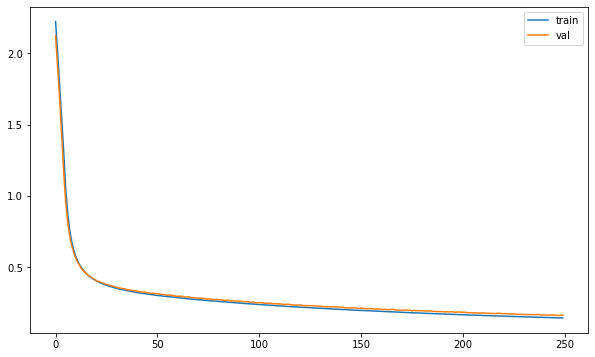

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='val')
plt.legend(['train', 'val'])

# 3. Improve model

## 3-1. Add dropout

Let's apply dropout to the 2-layer MLP.  
Set dropout probability with 0.2 for input, and 0.5 for hidden units.

In [33]:
class MLP2(nn.Module):
    def __init__(self, hidden_dim):
        super(MLP2, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 10),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits 

In [34]:
epochs = 250

model = MLP2(hidden_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
train_loss, val_loss = list(), list()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    _, loss = val(val_dataloader, model)
    val_loss.append(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.305647 [    0/50000]
  50th batch loss: 2.203295 [25600/50000]
Validation Error: 
 Accuracy: 60.3%, Avg loss: 2.067542 

Epoch 2
-------------------------------
   0th batch loss: 2.055311 [    0/50000]
  50th batch loss: 1.899060 [25600/50000]
Validation Error: 
 Accuracy: 65.6%, Avg loss: 1.738976 

Epoch 3
-------------------------------
   0th batch loss: 1.743011 [    0/50000]
  50th batch loss: 1.519800 [25600/50000]
Validation Error: 
 Accuracy: 74.2%, Avg loss: 1.397785 

Epoch 4
-------------------------------
   0th batch loss: 1.400440 [    0/50000]
  50th batch loss: 1.277006 [25600/50000]
Validation Error: 
 Accuracy: 78.5%, Avg loss: 1.118135 

Epoch 5
-------------------------------
   0th batch loss: 1.164600 [    0/50000]
  50th batch loss: 1.000087 [25600/50000]
Validation Error: 
 Accuracy: 80.5%, Avg loss: 0.925723 

Epoch 6
-------------------------------
   0th batch loss: 0.897733 [    0/50000]
  50th b

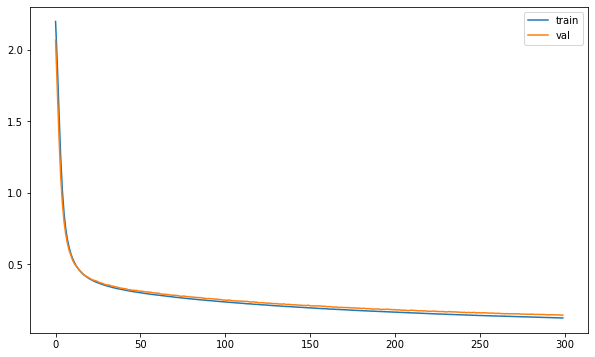

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='val')
plt.legend(['train', 'val'])

## 3-2. Apply data augmentation (visualization)

we cannot apply horizontal flip or vertical flip because it can cause a serious problem(e.g. 6 <-> 9)  
RandomRotation should be used carefully(the degree of rotation should be less than 30 degree)  
we can apply noise injection, affine distortion, translation, or elastic deformation

In [25]:
aug_fn = Compose([ToTensor(),
                  ColorJitter(brightness=(0.2, 3)),
                  RandomAffine(degrees=(-20, 20), translate=(0.2, 0.2)),
                  RandomResizedCrop(size=(28,28), scale=(0.8, 1.0), ratio=(0.75, 1.33))])

In [26]:
data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=aug_fn
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_data, val_data = random_split(data, [50000, 10000])

print("length of train data: ", len(train_data))
print("length of val data: ", len(val_data))
print("length of test data: ", len(test_data))

length of train data:  50000
length of val data:  10000
length of test data:  10000


In [27]:
train_dataloader = DataLoader(train_data, 
                             batch_size=batch_size,
                             shuffle=True,
                             drop_last=True)
val_dataloader = DataLoader(val_data, 
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=True)
test_dataloader = DataLoader(test_data, 
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=True)

Visualizing augmented data

In [18]:
def display_augmented_images(aug_f):
    fig, subplots = plt.subplots(2, 5, figsize=(13, 6))
    for i in range(5):
        axi1 = subplots.flat[i]
        axi2 = subplots.flat[i+5]

        original_img = Image.fromarray(np.array(data.data[i]))
        augmented_img = Image.fromarray(np.array(aug_f(original_img)))

        axi1.imshow(original_img)
        axi2.imshow(augmented_img)
        axi1.set_title('original_img')
        axi2.set_title('augmented_img')

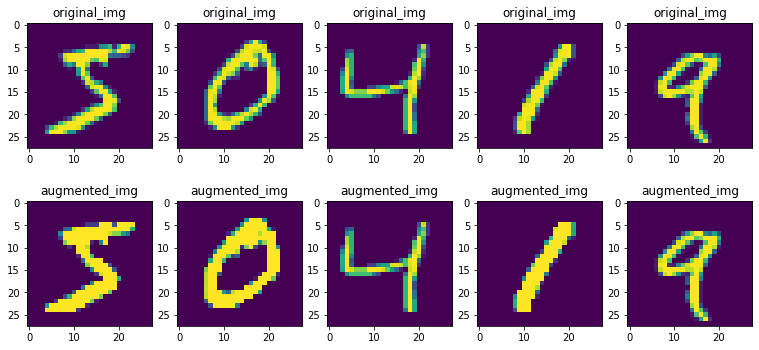

In [19]:
display_augmented_images(ColorJitter(brightness=(0.2, 3)))

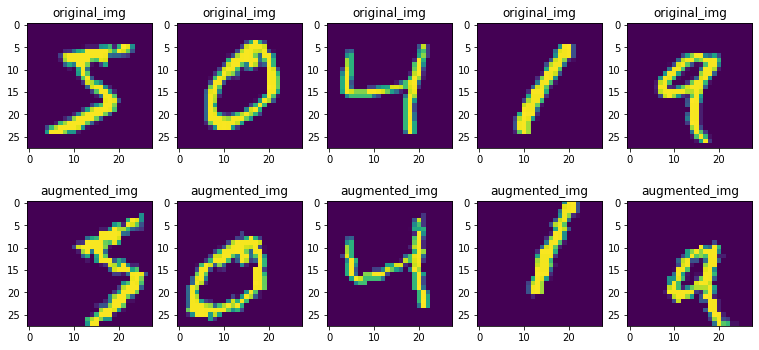

In [20]:
display_augmented_images(RandomAffine(degrees=(-20, 20), translate=(0.2, 0.2)))

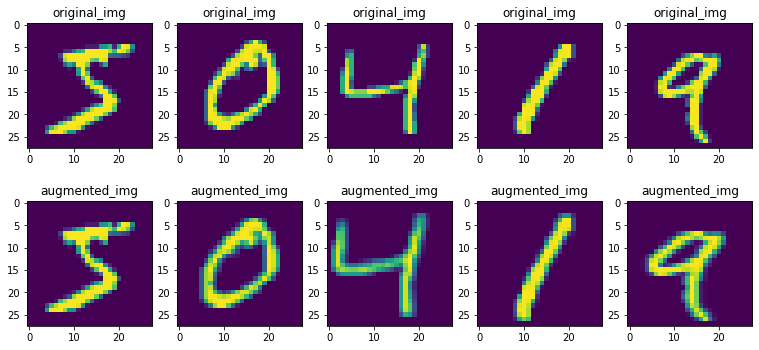

In [21]:
display_augmented_images(RandomResizedCrop(size=(28,28), scale=(0.8, 1.0), ratio=(0.75, 1.33)))

In [22]:
epochs = 250
learning_rate=1e-2

model = MLP1(hidden_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
train_loss, val_loss = list(), list()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    _, loss = val(val_dataloader, model)
    val_loss.append(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.298566 [    0/50000]
  50th batch loss: 2.289264 [25600/50000]
Validation Error: 
 Accuracy: 15.4%, Avg loss: 2.283087 

Epoch 2
-------------------------------
   0th batch loss: 2.281748 [    0/50000]
  50th batch loss: 2.277722 [25600/50000]
Validation Error: 
 Accuracy: 19.2%, Avg loss: 2.267758 

Epoch 3
-------------------------------
   0th batch loss: 2.265594 [    0/50000]
  50th batch loss: 2.263359 [25600/50000]
Validation Error: 
 Accuracy: 21.6%, Avg loss: 2.249586 

Epoch 4
-------------------------------
   0th batch loss: 2.251617 [    0/50000]
  50th batch loss: 2.243064 [25600/50000]
Validation Error: 
 Accuracy: 23.0%, Avg loss: 2.233144 

Epoch 5
-------------------------------
   0th batch loss: 2.234716 [    0/50000]
  50th batch loss: 2.224471 [25600/50000]
Validation Error: 
 Accuracy: 24.6%, Avg loss: 2.213381 

Epoch 6
-------------------------------
   0th batch loss: 2.207381 [    0/50000]
  50th b

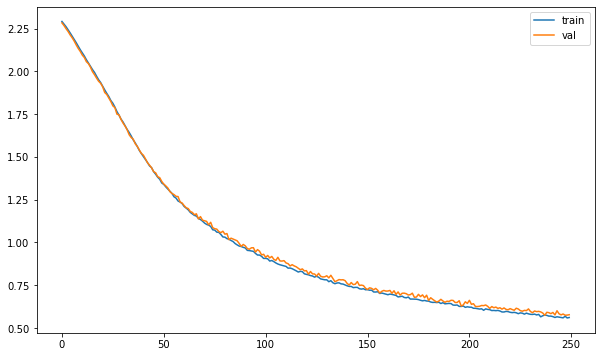

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='val')
plt.legend(['train', 'val'])

In [24]:
test(test_dataloader, model)

Test Accuracy: 88.2%


## 3-3. Change the depth of the network

Let's try with the deeper networks.  
MLP3 with 3 layers and MLP4 with 4 layers.  
Train the models with more epochs because the models become deeper.

In [18]:
# Change the depth of the network
class MLP3(nn.Module):
    def __init__(self):
        super(MLP3, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits 

In [19]:
epochs = 300
learning_rate=1e-2

model = MLP3().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
train_loss, val_loss = list(), list()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    _, loss = val(val_dataloader, model)
    val_loss.append(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.303248 [    0/50000]
  50th batch loss: 2.291212 [25600/50000]
Validation Error: 
 Accuracy: 36.6%, Avg loss: 2.275495 

Epoch 2
-------------------------------
   0th batch loss: 2.276608 [    0/50000]
  50th batch loss: 2.260020 [25600/50000]
Validation Error: 
 Accuracy: 44.0%, Avg loss: 2.234682 

Epoch 3
-------------------------------
   0th batch loss: 2.233639 [    0/50000]
  50th batch loss: 2.207052 [25600/50000]
Validation Error: 
 Accuracy: 45.9%, Avg loss: 2.177563 

Epoch 4
-------------------------------
   0th batch loss: 2.180087 [    0/50000]
  50th batch loss: 2.141303 [25600/50000]
Validation Error: 
 Accuracy: 46.3%, Avg loss: 2.090735 

Epoch 5
-------------------------------
   0th batch loss: 2.080651 [    0/50000]
  50th batch loss: 2.043121 [25600/50000]
Validation Error: 
 Accuracy: 46.8%, Avg loss: 1.968210 

Epoch 6
-------------------------------
   0th batch loss: 1.963398 [    0/50000]
  50th b

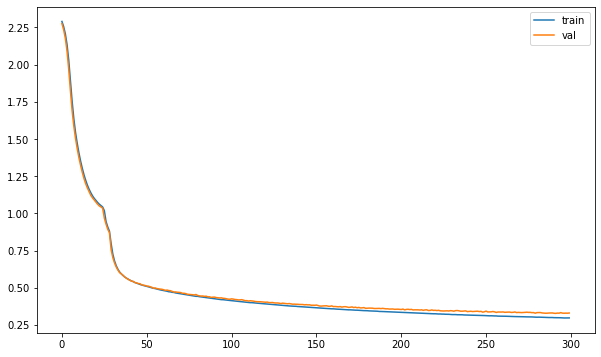

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='val')
plt.legend(['train', 'val'])

In [23]:
test(test_dataloader, model)

Test Accuracy: 94.0%


Test accuracy is similar with the previous model.   
The best epoch size for 3-layer MLP is about 150.

In [24]:
# Change the depth of the network
class MLP4(nn.Module):
    def __init__(self):
        super(MLP4, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits 

In [25]:
epochs = 300
learning_rate=1e-2

model = MLP4().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
train_loss, val_loss = list(), list()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    _, loss = val(val_dataloader, model)
    val_loss.append(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.302261 [    0/50000]
  50th batch loss: 2.300253 [25600/50000]
Validation Error: 
 Accuracy: 19.4%, Avg loss: 2.298696 

Epoch 2
-------------------------------
   0th batch loss: 2.297417 [    0/50000]
  50th batch loss: 2.296991 [25600/50000]
Validation Error: 
 Accuracy: 27.5%, Avg loss: 2.294409 

Epoch 3
-------------------------------
   0th batch loss: 2.294235 [    0/50000]
  50th batch loss: 2.291058 [25600/50000]
Validation Error: 
 Accuracy: 32.3%, Avg loss: 2.289090 

Epoch 4
-------------------------------
   0th batch loss: 2.287832 [    0/50000]
  50th batch loss: 2.287952 [25600/50000]
Validation Error: 
 Accuracy: 33.2%, Avg loss: 2.282816 

Epoch 5
-------------------------------
   0th batch loss: 2.282096 [    0/50000]
  50th batch loss: 2.277081 [25600/50000]
Validation Error: 
 Accuracy: 33.4%, Avg loss: 2.274577 

Epoch 6
-------------------------------
   0th batch loss: 2.274618 [    0/50000]
  50th b

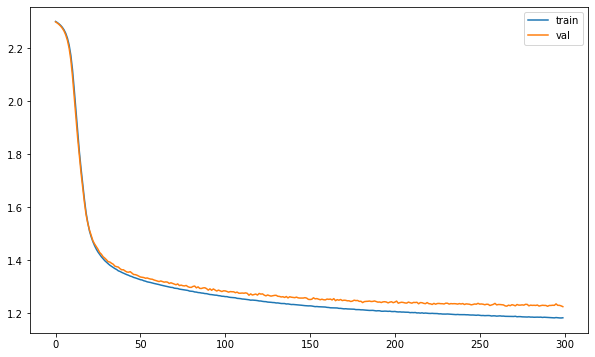

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='val')
plt.legend(['train', 'val'])

In [27]:
test(test_dataloader, model)

Test Accuracy: 47.3%


The 4-layer MLP also too deep(capacity is too large) for the MNIST dataset.

## 3-4. Change the optimizer or learning rate scheduler

3-4-1. [Change the optimizer](#3-4-1.-Change-the-optimizer)  
3-4-2. [Change the learning rate scheduler](#3-4-2.-Change-the-learning-rate-scheduler)

## 3-4-1. Change the optimizer  
Try Adam optimizer.

In [38]:
epochs = 100

model = MLP1(hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters())
    
train_loss, val_loss = list(), list()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    _, loss = val(val_dataloader, model)
    val_loss.append(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.305132 [    0/50000]
  50th batch loss: 1.154784 [25600/50000]
Validation Error: 
 Accuracy: 55.1%, Avg loss: 1.093585 

Epoch 2
-------------------------------
   0th batch loss: 1.116788 [    0/50000]
  50th batch loss: 1.034792 [25600/50000]
Validation Error: 
 Accuracy: 56.4%, Avg loss: 1.037421 

Epoch 3
-------------------------------
   0th batch loss: 1.125995 [    0/50000]
  50th batch loss: 1.008575 [25600/50000]
Validation Error: 
 Accuracy: 56.9%, Avg loss: 1.011237 

Epoch 4
-------------------------------
   0th batch loss: 1.064248 [    0/50000]
  50th batch loss: 0.926300 [25600/50000]
Validation Error: 
 Accuracy: 57.1%, Avg loss: 0.995317 

Epoch 5
-------------------------------
   0th batch loss: 0.973265 [    0/50000]
  50th batch loss: 0.991391 [25600/50000]
Validation Error: 
 Accuracy: 65.8%, Avg loss: 0.891782 

Epoch 6
-------------------------------
   0th batch loss: 0.966191 [    0/50000]
  50th b

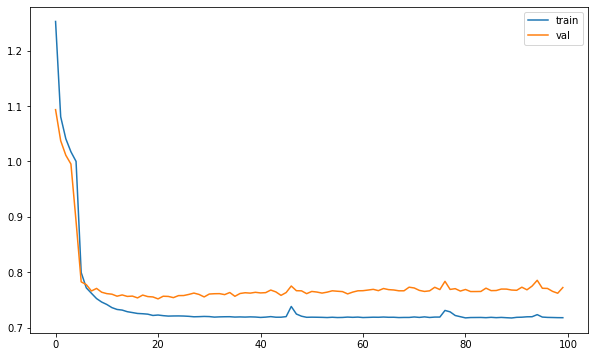

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='val')
plt.legend(['train', 'val'])

Adam optimizer converges faster than SGD, but SGD has lower validation loss than Adam.  
We might guess that SGD is better for shallow network than Adam.

## 3-4-2. Change the learning rate scheduler  
ReduceLROnPlateau: dynamic learning rate reducing based on some validation measurements.

In [14]:
epochs = 250
learning_rate=1e-2

model = MLP1(hidden_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_loss, val_loss = list(), list()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    _, loss = val(val_dataloader, model)
    val_loss.append(loss)
    scheduler.step(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.303725 [    0/50000]
  50th batch loss: 2.221677 [25600/50000]
Validation Error: 
 Accuracy: 47.5%, Avg loss: 2.146980 

Epoch 2
-------------------------------
   0th batch loss: 2.143752 [    0/50000]
  50th batch loss: 2.063694 [25600/50000]
Validation Error: 
 Accuracy: 48.9%, Avg loss: 1.979179 

Epoch 3
-------------------------------
   0th batch loss: 1.982738 [    0/50000]
  50th batch loss: 1.843219 [25600/50000]
Validation Error: 
 Accuracy: 50.5%, Avg loss: 1.813185 

Epoch 4
-------------------------------
   0th batch loss: 1.828566 [    0/50000]
  50th batch loss: 1.710115 [25600/50000]
Validation Error: 
 Accuracy: 51.9%, Avg loss: 1.679018 

Epoch 5
-------------------------------
   0th batch loss: 1.630192 [    0/50000]
  50th batch loss: 1.695622 [25600/50000]
Validation Error: 
 Accuracy: 53.0%, Avg loss: 1.580508 

Epoch 6
-------------------------------
   0th batch loss: 1.651345 [    0/50000]
  50th b

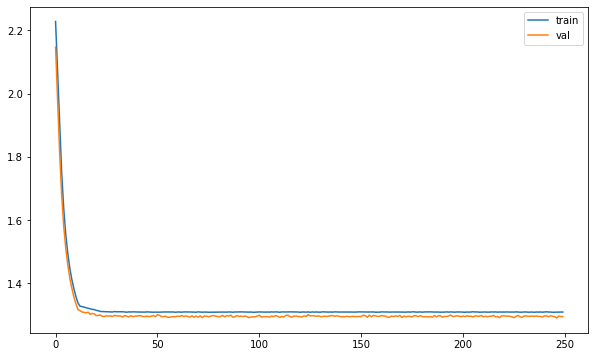

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='val')
plt.legend(['train', 'val'])

After 25~30 epochs, learning rate is reduced because no improvement is seen for a 10(=patience) epochs by ReduceLROnPlateau.

## 3-5. Add L2 regularization

Let's try various hyperparameters alpha.  
Values of the alpha to be tested: 0.1, 0.01, 0.001, 0.0001

In [16]:
alphas = [0.1, 0.01, 0.001, 0.0001]
epochs = 10
learning_rate = 1e-2

val_accuracy, val_loss = dict(), dict()

for alpha in alphas:
    model = MLP1(hidden_dim).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=alpha)
    
    accuracy, loss = list(), list()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        _= train(train_dataloader, model, criterion, optimizer) 
        temp1, temp2 = val(val_dataloader, model)
        accuracy.append(temp1)
        loss.append(temp2)
    
    val_accuracy[alpha] = accuracy
    val_loss[alpha] = loss

Epoch 1
-------------------------------
   0th batch loss: 2.299241 [    0/50000]
  50th batch loss: 2.181244 [25600/50000]
Validation Error: 
 Accuracy: 61.6%, Avg loss: 2.084950 

Epoch 2
-------------------------------
   0th batch loss: 2.081835 [    0/50000]
  50th batch loss: 1.969460 [25600/50000]
Validation Error: 
 Accuracy: 65.9%, Avg loss: 1.868960 

Epoch 3
-------------------------------
   0th batch loss: 1.870852 [    0/50000]
  50th batch loss: 1.751127 [25600/50000]
Validation Error: 
 Accuracy: 70.2%, Avg loss: 1.652786 

Epoch 4
-------------------------------
   0th batch loss: 1.639710 [    0/50000]
  50th batch loss: 1.527302 [25600/50000]
Validation Error: 
 Accuracy: 72.9%, Avg loss: 1.462143 

Epoch 5
-------------------------------
   0th batch loss: 1.448093 [    0/50000]
  50th batch loss: 1.354678 [25600/50000]
Validation Error: 
 Accuracy: 75.5%, Avg loss: 1.312657 

Epoch 6
-------------------------------
   0th batch loss: 1.360607 [    0/50000]
  50th b

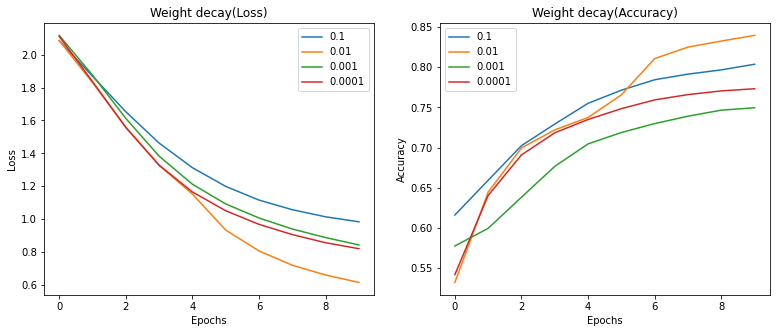

In [17]:
# Comparing between learning rates
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Weight decay(Loss)')
for alpha in alphas:
    ax1.plot(range(epochs), val_loss[alpha], label=alpha)
    ax1.legend(alphas)

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Weight decay(Accuracy)')
for alpha in alphas:
    ax2.plot(range(epochs), val_accuracy[alpha], label=alpha)
    ax2.legend(alphas)
    
plt.show()

Best alpha value for weight decay is 0.001~0.0001.

## Extra) Apply all togethers..

In [17]:
class MLP5(nn.Module):
    def __init__(self):
        super(MLP5, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits 

In [28]:
epochs = 100
learning_rate=1e-2
alpha = 1e-3

model = MLP5().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=alpha, momentum=0.9)
train_loss, val_loss, val_acc = list(), list(), list()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, model, criterion, optimizer))
    acc, loss = val(val_dataloader, model)
    val_acc.append(acc)
    val_loss.append(loss)

Epoch 1
-------------------------------
   0th batch loss: 2.302768 [    0/50000]
  30th batch loss: 2.298944 [15360/50000]
  60th batch loss: 2.292185 [30720/50000]
  90th batch loss: 2.283293 [46080/50000]
Validation Error: 
 Accuracy: 24.1%, Avg loss: 2.276785 

Epoch 2
-------------------------------
   0th batch loss: 2.272665 [    0/50000]
  30th batch loss: 2.271613 [15360/50000]
  60th batch loss: 2.231539 [30720/50000]
  90th batch loss: 2.215035 [46080/50000]
Validation Error: 
 Accuracy: 26.7%, Avg loss: 2.193108 

Epoch 3
-------------------------------
   0th batch loss: 2.199773 [    0/50000]
  30th batch loss: 2.178251 [15360/50000]
  60th batch loss: 2.112434 [30720/50000]
  90th batch loss: 2.045221 [46080/50000]
Validation Error: 
 Accuracy: 31.9%, Avg loss: 2.032921 

Epoch 4
-------------------------------
   0th batch loss: 2.089432 [    0/50000]
  30th batch loss: 1.974426 [15360/50000]
  60th batch loss: 1.940086 [30720/50000]
  90th batch loss: 1.909434 [46080/5

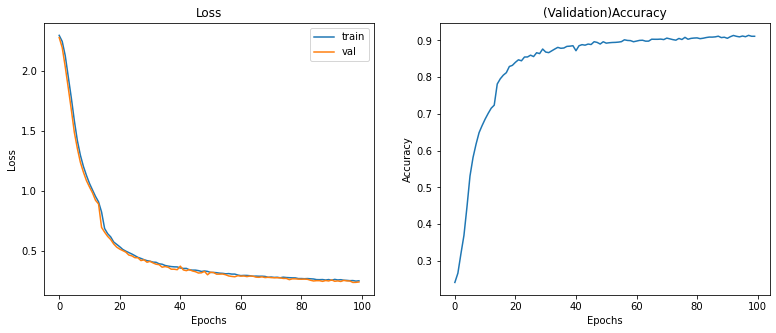

In [35]:
# Comparing between learning rates
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.plot(range(epochs), train_loss, label='train')
ax1.plot(range(epochs), val_loss, label='val')
ax1.legend(['train', 'val'])

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('(Validation)Accuracy')
ax2.plot(range(epochs), val_acc)
    
plt.show()

In [34]:
test(test_dataloader, model)

Test Accuracy: 93.9%
